In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor
from PIL import Image
from tqdm import tqdm
import os,json
from utils_evaluate_model import *
from models import * 
import torchvision.utils as vutils
import os, time

In [10]:
image_name = "non_gaussian"
model_name = "SWD"

im_name_to_path = {
    "oiseau" : "images/oiseau.png",
    "zebre" : "images/zebre.png",
    "gaussian" : "images/gaussian.png",
    "non_gaussian" : "images/non_gaussian.png",
    "london" : "images/london.jpg",
    "motif" : "images/motif.png",
    "herbe" : "images/herbe.png"
}

In [11]:

model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")


4 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-06-27T13:57:26
N_scales: 4
base_iter: 2000
lr: 0.001
betas: (0.9, 0.999)
alpha_rec: 10.0
beta_sigma: 0.1
lambda_swd_init: [0.4000000059604645, 0.699999988079071, 1.0]
lamda_swd_total: 1.0
r: 2
comment: Entraînement rapide SWD multi-échelle + MSE, sans discriminateur.
────────────────────────

sigma_n chargé (4 éléments) → 'loaded_sigma_n'
z_star chargé de taille (3, 31, 31) → 'loaded_z_star'
4 générateurs instanciés → 'loaded_generators'


In [12]:
loaded_params = {}
with open(descr_fp, encoding="utf-8") as f:
    for line in f:
        if ": " not in line:
            continue
        key, val = line.strip().split(": ", 1)
        loaded_params[key] = val

# Conversion au bon type
loaded_N = int(loaded_params["N_scales"])
loaded_r = float(loaded_params["r"])  

In [13]:
loaded_params

{'date': '2025-06-27T13:57:26',
 'N_scales': '4',
 'base_iter': '2000',
 'lr': '0.001',
 'betas': '(0.9, 0.999)',
 'alpha_rec': '10.0',
 'beta_sigma': '0.1',
 'lambda_swd_init': '[0.4000000059604645, 0.699999988079071, 1.0]',
 'lamda_swd_total': '1.0',
 'r': '2',
 'comment': 'Entraînement rapide SWD multi-échelle + MSE, sans discriminateur.'}

In [14]:
path = im_name_to_path[image_name]
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
print(f"inital tensor size : {im_tensor_cpu.shape}")

max_dim = 250
_, H, W = im_tensor_cpu.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_cpu.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

# Compute the different scales
scales = [im_resized.unsqueeze(0)]  

for i in range(0, loaded_N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / loaded_r), 1)
    new_w = max(int(w / loaded_r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


inital tensor size : torch.Size([3, 306, 306])
rescaled tensor size : torch.Size([3, 250, 250])


saved → 50/non_gaussian/1.png
saved → 50/non_gaussian/2.png
saved → 50/non_gaussian/3.png
saved → 50/non_gaussian/4.png
saved → 50/non_gaussian/5.png
saved → 50/non_gaussian/6.png
saved → 50/non_gaussian/7.png
saved → 50/non_gaussian/8.png


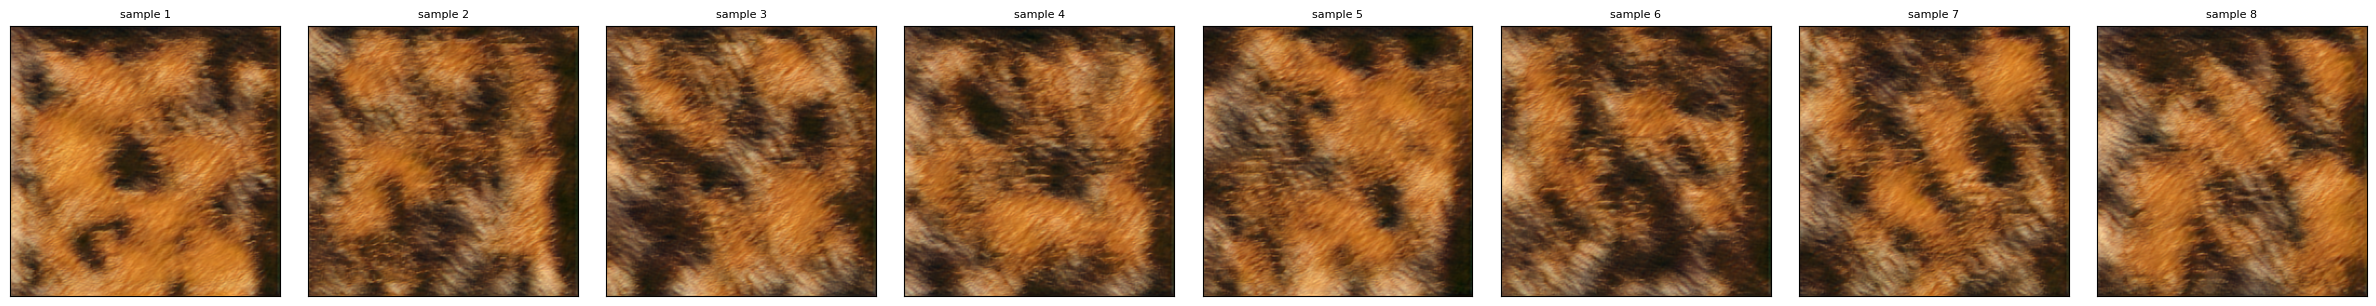

In [15]:
# dossier de sortie
out_dir = "50/" + image_name
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(imgs_ref=scales, Generators=loaded_generators,sigma_n=loaded_sigma_n,N=loaded_N,device=device,start_scale=loaded_N-1)
    final_imgs.append(imgs[0].cpu().squeeze())      # 0 : finest scale , -1 :  coarest sclae

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


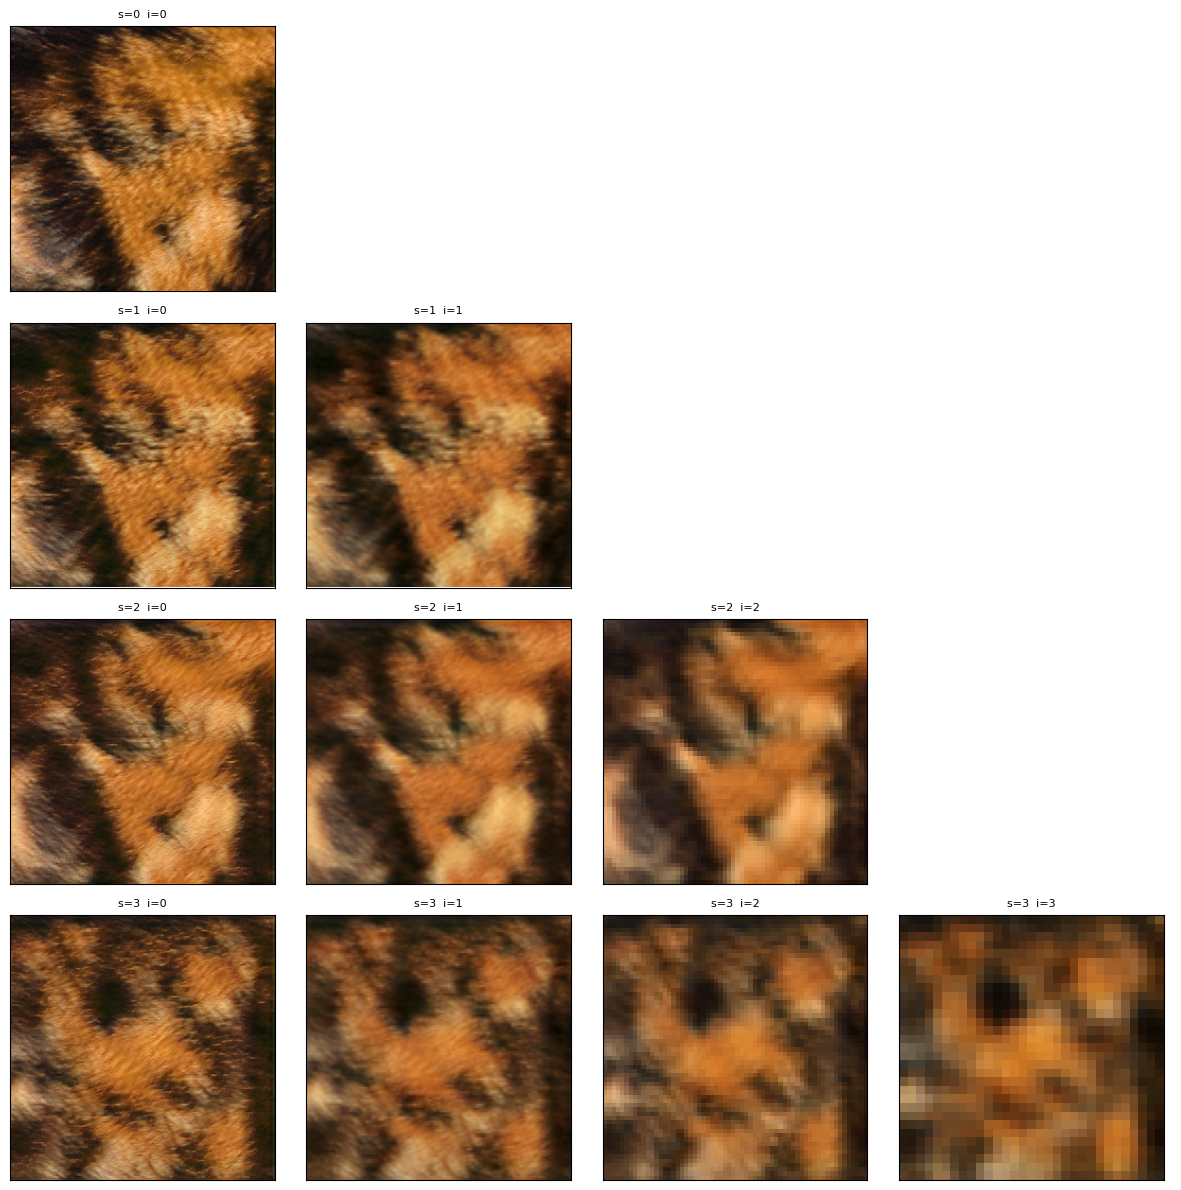

In [16]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(loaded_N):
    imgs =  generate_multiscale(imgs_ref=scales, Generators=loaded_generators,sigma_n=loaded_sigma_n,N=loaded_N,device=device,start_scale=s)
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * loaded_N
fig, axes = plt.subplots(loaded_N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(loaded_N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()